In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import seaborn as sns
from math import  sqrt
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
import statistics as st
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import seaborn as sns
from math import  sqrt
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima -q
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("/content/Ethereum Historical Data.csv")


In [ ]:
#index
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index(['Date'])


In [ ]:
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,3815.95,3762.63,3832.35,3753.32,143.81K,1.42%
2024-05-31,3762.66,3747.89,3844.96,3724.57,294.56K,0.40%
2024-05-30,3747.55,3767.22,3824.94,3703.74,293.81K,-0.58%
2024-05-29,3769.57,3845.56,3886.44,3745.72,353.25K,-1.98%
2024-05-28,3845.56,3894.33,3929.21,3775.08,436.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16.74M,8.61%
2019-03-04,125.97,131.02,131.57,123.25,14.11M,-3.85%
2019-03-03,131.01,132.77,168.42,129.05,10.64M,-1.32%


**#Differencing **

In [ ]:
df['Price_diff'] = df['Price'].diff(periods=12)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2024-06-01 to 2019-03-01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       1920 non-null   float64
 1   Open        1920 non-null   float64
 2   High        1920 non-null   float64
 3   Low         1920 non-null   float64
 4   Vol.        1920 non-null   object 
 5   Change %    1920 non-null   object 
 6   Price_diff  1908 non-null   float64
dtypes: float64(5), object(2)
memory usage: 120.0+ KB


In [ ]:
df['Price_diff'].fillna(method='backfill', inplace=True)


**Identify Seasonal Component**

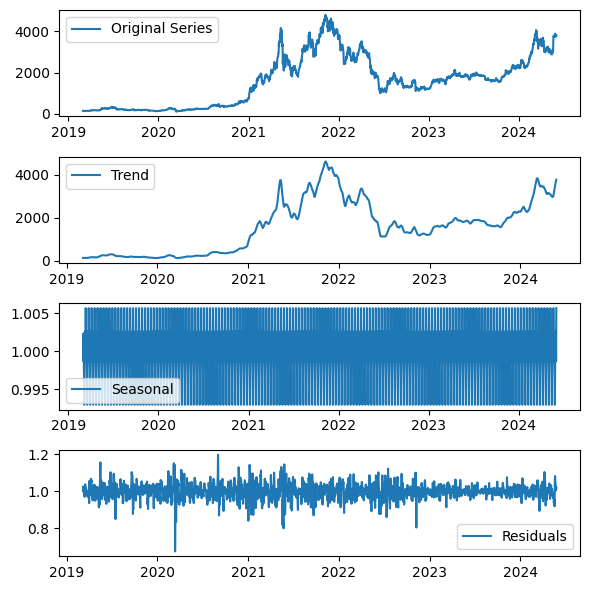

In [ ]:
result = seasonal_decompose(df['Price'], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(df['Price'], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
df['date_index'] = df.index.date


**SARIMAX Model Fitting**

In [ ]:
SARIMAX_model = pm.auto_arima(df[['Price']], exogenous=df[['date_index']],
						start_p=1, start_q=1,
						test='adf',
						max_p=3, max_q=3, m=12,
						start_P=0, seasonal=True,
						d=None, D=1,
						trace=False,
						error_action='ignore',
						suppress_warnings=True,
						stepwise=True)


In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
	# Forecast
	n_periods = periods

	forecast_df = pd.DataFrame({"date_index": pd.date_range(df.index[-1], periods=n_periods, freq='MS').month},
							index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS'))

	fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
											return_conf_int=True,
											exogenous=forecast_df[['date_index']])
	index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

	# make series for plotting purpose
	fitted_series = pd.Series(fitted, index=index_of_fc)
	lower_series = pd.Series(confint[:, 0], index=index_of_fc)
	upper_series = pd.Series(confint[:, 1], index=index_of_fc)

	# Plot
	plt.figure(figsize=(15, 7))
	plt.plot(df["Price"], color='#1f76b4')
	plt.plot(fitted_series, color='darkgreen')
	plt.fill_between(lower_series.index,
					lower_series,
					upper_series,
					color='k', alpha=.15)

	plt.title("SARIMAX - Forecast")
	plt.show()


**SARIMAX forecasting function**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


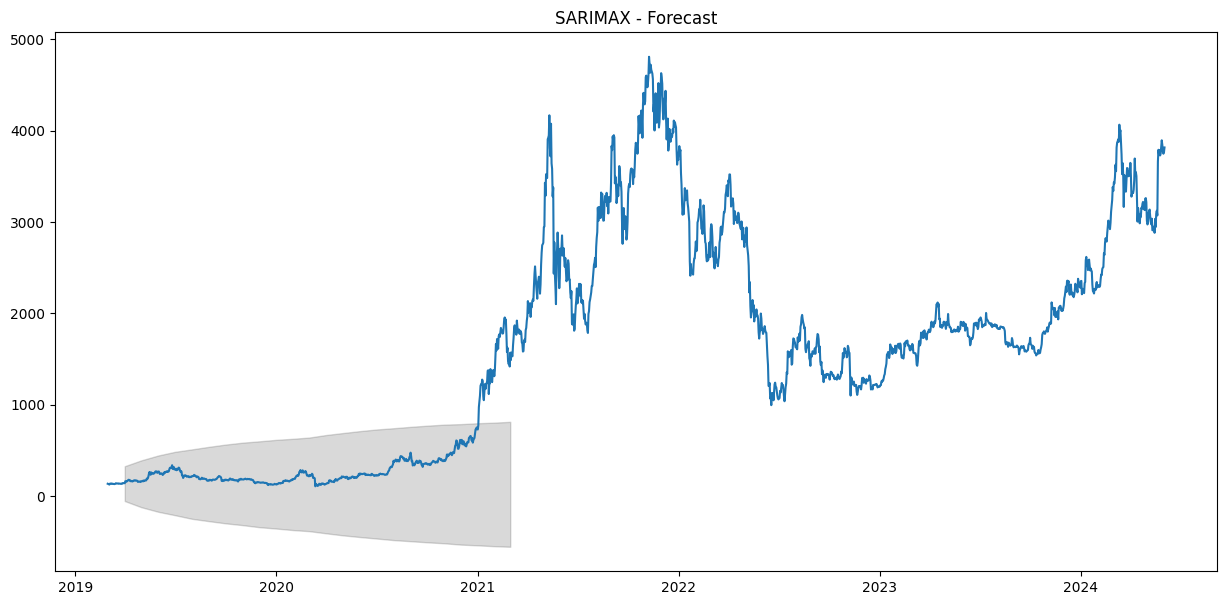

In [ ]:
sarimax_forecast(SARIMAX_model, periods=24)


In [ ]:
df['Date'] = pd.to_datetime(df['Date']).dt.month
df['Date_square'] = df['Date']* df['Date']
df['Date_^3'] = df['Date_square']*df['Date']

KeyError: 'Date'

In [ ]:

df

In [ ]:
df['Gas Use Dif'] = df['Gas Use '].diff(periods=12)
df.info()

df['Gas Use Dif'].fillna(method='backfill', inplace=True)


In [ ]:

result = seasonal_decompose(df['Gas Use '], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(df['Gas Use '], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
Gas_Arima = pm.auto_arima(df['Gas Use '], m=7, trace = True)
Gas_Arima.summary()

In [ ]:
#SARIMAX(2, 0, 0)x(1, 1, 0, 7)
n = int(len(df)*0.6)
train = df[:n]
test = df[n:]
model = SARIMAX(train['Gas Use '],order=(2,0,0),seasonal_order=(1,1,0,7))
result = model.fit()
start = len(train)
end = len(train) + len(test)-1
prediction = result.predict(start,end).rename('Prediction')
#ax=test['Gas Use '].plot(legend = True, figsize=(16,8))
#prediction.plot(legend = True)
plt.figure(figsize=(16, 8))
plt.plot( train['Gas Use '], label='train', color='green')
plt.plot( test['Gas Use '], label='reality', color='blue')
plt.plot( prediction, label='Prediction', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error ,mean_absolute_error

from math import  sqrt
mae = mean_absolute_error(test['Gas Use '],prediction)
rmse = sqrt(mean_squared_error(test['Gas Use '],prediction))
print("Mae: ",round(mae, 3))
print("RMSE: ",round(rmse, 3))

In [ ]:
pred = result.forecast(12)
plt.figure(figsize=(16, 8))
plt.plot( train['Gas Use '], label='train', color='green')
plt.plot( test['Gas Use '], label='reality', color='blue')
plt.plot( pred, label='Prediction 12 months', color='red')
plt.legend()
plt.ylabel('Value')
plt.show()

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"Month": pd.date_range(df.index[-1], periods=n_periods, freq='MS').month},
                               index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['Month']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df["Gas Use"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Gas Use ")
    plt.show()

